# Plot Trajectories
This is script will create a sample plot of trajectories calculated from "backwards_trajectories.ipynb". It contains two subplots: trajectories in the x-y and x-z plane.  

# Load Modules

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os, sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.patheffects as PathEffects
import scipy.ndimage

sys.path.append('/uufs/chpc.utah.edu/common/home/u1013082/lake_effect/modules')
import nclcmaps

# Read in Trajectory Data

In [2]:
xpos = np.load('/uufs/chpc.utah.edu/common/home/u1013082/lake_effect/cm1/trajectory_data/xpos_0000m_tug_forward.npy')
ypos = np.load('/uufs/chpc.utah.edu/common/home/u1013082/lake_effect/cm1/trajectory_data/ypos_0000m_tug_forward.npy')
zpos = np.load('/uufs/chpc.utah.edu/common/home/u1013082/lake_effect/cm1/trajectory_data/zpos_0000m_tug_forward.npy')
variable1 = np.load('/uufs/chpc.utah.edu/common/home/u1013082/lake_effect/cm1/trajectory_data/th_0000m_tug_forward.npy')

# xpos = np.load('/uufs/chpc.utah.edu/common/home/u1013082/lake_effect/cm1/trajectory_data/xpos_0000m_tug_back.npy')
# ypos = np.load('/uufs/chpc.utah.edu/common/home/u1013082/lake_effect/cm1/trajectory_data/ypos_0000m_tug_back.npy')
# zpos = np.load('/uufs/chpc.utah.edu/common/home/u1013082/lake_effect/cm1/trajectory_data/zpos_0000m_tug_back.npy')
# variable1 = np.load('/uufs/chpc.utah.edu/common/home/u1013082/lake_effect/cm1/trajectory_data/th_0000m_tug_back.npy')

# Read in Model Data for Domain Info

In [3]:
#Read in model data
ds = xr.open_dataset('/uufs/chpc.utah.edu/common/home/steenburgh-group8/tom/cm1/output/12ms_0000m_tug.nc', chunks={'nk': 1})
#Horizontal resolution of model output (meters)
hor_resolution = (ds.xf[1].values-ds.xf[0].values)*1000

#Get surface height grid (set to zero if no terrain)
try:
    zs = np.array(ds.zs[0,:,:])
except:
    zs = np.zeros((ds.ny, ds.nx))  

# Create Cluster

In [4]:
from dask.distributed import Client, LocalCluster
c = LocalCluster(n_workers = 10, threads_per_worker=1)
client = Client(c)

/uufs/chpc.utah.edu/common/home/u1013082/miniconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


# Model Info

In [5]:
#Plot Dimensions
top = 41
left = 0

ymid = np.int(ds.ny/2)
x1d = ds.xh[left:].values
y1d = ds.yh.values
x2d = np.rot90(np.repeat(x1d,top, axis = 0).reshape(ds.nx-left,top))
y2d = np.rot90(np.repeat(y1d,top, axis = 0).reshape(ds.ny-left,top))
z2dxz = np.repeat(ds.z[:top].values*1000,ds.nx-left, axis = 0).reshape(top, ds.nx-left)
z2dyz = np.repeat(ds.z[:top].values*1000,ds.ny-left, axis = 0).reshape(top, ds.ny-left)
#y2d_500 = dsj500.zh[0,:top,ymid,left:].values*z_scale
#y2d_2000 = dsj2000.zh[0,:top,ymid,left:].values*z_scale

#Model output
time = 400

#qcxy = ds.qc[time,:top,:,:]
#qrxy = ds.qr[time,:top,:,:]
#qixy = ds.qi[time,:top,:,:]
#qgxy = ds.qg[time,:top,:,:]
#qsxy = ds.qs[time,:top,:,:]
#Total
#qxy  = (qcxy + qrxy + qixy + qgxy + qsxy).max(dim = ('nk')).values*1000
qxy  = ds.cref[time,:,:].values
uxy  = ds.uinterp[time-5:time+5,0,:,:].mean(dim = 'time').values
vxy  = ds.vinterp[time-5:time+5,0,:,:].mean(dim = 'time').values
thxy  = ds.th[time-10:time+10,0,:,:].mean(dim = 'time').values

#qcxz = ds.qc[time,:top,:,:]
#qrxz = ds.qr[time,:top,:,:]
#qixz = ds.qi[time,:top,:,:]
#qgxz = ds.qg[time,:top,:,:]
#qsxz = ds.qs[time,:top,:,:]
#Total
#qxz  = (qcxz + qrxz + qixz + qgxz + qsxz).max(dim = ('nj')).values*1000
qxz  = ds.dbz[time,:top,ymid,:].values
uxz  = ds.uinterp[time-5:time+5,:top,ymid,:].mean(dim = 'time').values
wxz  = ds.winterp[time-5:time+5,:top,ymid,:].mean(dim = 'time').values
thxz  = ds.th[time-10:time+10,:top,ymid,:].mean(dim = 'time').values


#qcyz = ds.qc[time,:top,:,:]
#qryz = ds.qr[time,:top,:,:]
#qiyz = ds.qi[time,:top,:,:]
#qgyz = ds.qg[time,:top,:,:]
#qsyz = ds.qs[time,:top,:,:]
#Total
#qyz  = (qcyz + qryz + qiyz + qgyz + qsyz).max(dim = ('ni')).values*1000
qyz  = ds.dbz[time,:top,:,2800].values
vyz  = ds.vinterp[time-5:time+5,:top,:,2800].mean(dim = 'time').values
wyz  = ds.winterp[time-5:time+5,:top,:,2800].mean(dim = 'time').values
thyz  = ds.th[time-10:time+10,:top,:,2800].mean(dim = 'time').values


# Plot Trajectories

/uufs/chpc.utah.edu/common/home/u1013082/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/uufs/chpc.utah.edu/common/home/u1013082/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:179: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/uufs/chpc.utah.edu/common/home/u1013082/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In 

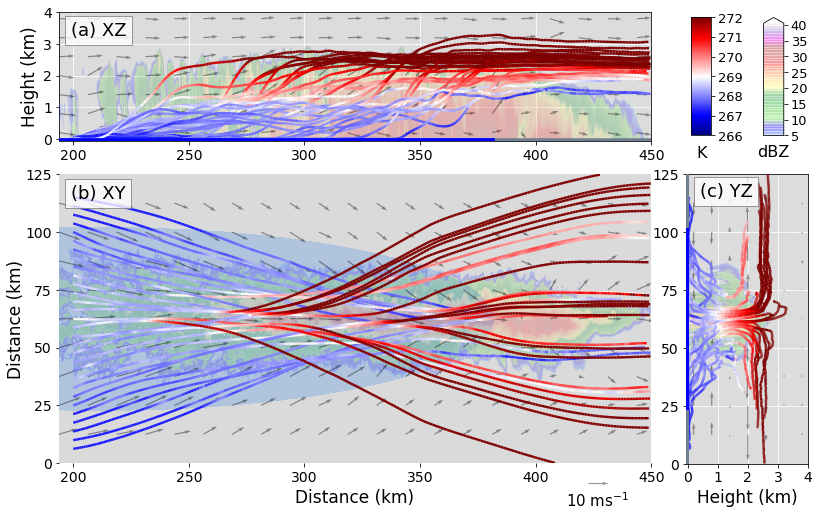

In [6]:
###############################################################################
############################ Trajectory Plot  #################################
###############################################################################

%matplotlib inline
fig = plt.figure(figsize=(15*0.75,9.5*0.75), facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.07, bottom=0.1, right=0.995, top=0.98, wspace=0.8, hspace=0.675)

#Color range of Varible1 (set by user)
xlmin = 266
xlmax = 272.01
xlevels = np.arange(xlmin,xlmax, 0.05)
xlevels_ticks = np.arange(xlmin,xlmax,1)
xlevels_ticks_labels = np.arange(xlmin,xlmax, 1).astype(int)


#Levels for qc
lmin = 5
lmax = 41
levels = (np.arange(lmin,lmax, 0.5))
levels_ticks = np.arange(lmin,lmax,5)
levels_ticks_labels = np.round(levels_ticks, 5)

#Levels for th
# lmin = 265
# lmax = 270
# levels = (np.arange(lmin,lmax, 1))
# levels_ticks = levels
# levels_ticks_labels = np.round(levels_ticks, 1)

#Colormaps
cmap = cm.Spectral_r
cmap = cm.Blues

#Colormap
colors1 = np.array(nclcmaps.colors['NCV_blue_red'])
colors_int = colors1.astype(int)
colors = list(colors_int)
cmap = nclcmaps.make_cmap(colors, bit=True)

#Colormap
colors1 = np.array(nclcmaps.colors['prcp_1'])
colors_int = colors1.astype(int)
colors = list(colors_int)
cmapf = nclcmaps.make_cmap(colors, bit=True)
#cmapf = cm.Greys
alpha = 0.25
width = 2.4
TF = True
alpha_traj = 1
alpah_barb = 0.4

#Dimensions
left = 1550
right = 3600
y_top = 1000
y_bot = 0

############  Functions for coloring lines with third variable ################

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

# Interface to LineCollection:

def colorline(x, y, z=None, cmap = cm.Spectral_r, norm=matplotlib.colors.BoundaryNorm(xlevels,cmap.N), linewidth=2, alpha=0.3):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))     
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z]) 
    z = np.asarray(z)
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha, zorder = 3)
    ax = plt.gca()
    ax.add_collection(lc)
    return lc

###################  Plot Trajectories in x-y plane ###############################

#Create Plot
ax = plt.subplot2grid((6, 10), (2, 0), rowspan=4, colspan = 8, aspect = 'equal')


#Plot cloud
plot = plt.contourf(qxy, levels, cmap = cmapf, extend = 'max', alpha = alpha,  zorder = 3, vmin = 0, antialiased = TF)

#Plot Wind (lowest level)
yy = np.arange(100, y_top, 100)
xx = np.arange(left, right, 100)
points = np.meshgrid(yy, xx)
x, y = np.meshgrid(yy, xx)
quiv = ax.quiver(y, x, uxy[points], vxy[points], zorder = 3, width = 0.002, scale = 300, edgecolor='white', alpha = alpah_barb)

# #Plot Theta
# thlmin = 265
# thlmax = 268.51
# thlevels = np.arange(thlmin,thlmax, 0.5)
# thxy_smooth= np.copy(scipy.ndimage.filters.uniform_filter(thxy, 50))
# theta_plot = plt.contour(thxy_smooth, thlevels, alpha = 1, cmap = cm.coolwarm, zorder = 3, linewidths = 1.8)
# clab = ax.clabel(theta_plot, theta_plot.levels[::1], fontsize=12, inline_spacing = 1, fmt='%1.1fK')
# plt.setp(clab, path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")], zorder = 10)




#Plot trajectories in x-y plane, colored by Variable1
#Plots trjectory with highest mean z first, then scond, then third...
zpos_seg = np.nanmean(zpos[:,:,:], axis = 0)
zord = np.argsort(zpos_seg[:,:])
for i in range(len(xpos[0,:,0])):
    for j in range(len(xpos[0,0,:])):
        ind  = zord[i, j]
        trajectories_xy = colorline(xpos[:,i,ind], ypos[:,i,ind], variable1[:,i,ind], cmap, alpha = alpha_traj, linewidth = width)

#Ticks and labels (set by user)
xticks = np.arange(0,ds.nx+1,400)
yticks = np.arange(0,ds.ny+1,200)
plt.xticks(xticks)
plt.yticks(yticks)
xtickslabs = (xticks*hor_resolution/1000).astype(int) #kilometers
ytickslabs = (yticks*hor_resolution/1000).astype(int) #kilometers
ax.set_xticklabels((xtickslabs), fontsize = 14)
ax.set_yticklabels((ytickslabs), fontsize = 14)
plt.ylabel('Distance (km)', fontsize = 17, labelpad = 0)
plt.xlabel('Distance (km)', fontsize = 17)

#Limits and characteristics (set by user)
plt.xlim(left,right)
plt.ylim(y_bot, y_top)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#Plot water and land (set by user)
levels_water = [1.5, 2.5]
levels_terrain = [0,1.5]
xland_plt = plt.contourf(ds.xland[0,:,:], levels_water, alpha = 1, colors = ('lightsteelblue'), zorder = 2)
xland_plt = plt.contourf(ds.xland[0,:,:], levels_terrain, alpha = 1, colors = ('gainsboro'), zorder = 1)

#Terrain (set by user)
terrain_levels = np.arange(-1, 2000.1, 100)
terrain = plt.contourf(zs[:,:], terrain_levels, alpha = 1, cmap = cm.Greys, vmin = -600, vmax = 2000, zorder = 1)

#Label
props = dict(boxstyle='square', facecolor='white', alpha=0.8, ec="gray")
ax.text(0.02, 0.915, '(b) XY',\
        transform=ax.transAxes, bbox = props, fontsize = 18, zorder = 20)

#Quiver
ax.quiverkey(quiv, X=0.91, Y=-0.07, U=10, label='10 $\mathregular{ms^{-1}}$', zorder = 20,labelpos = 'S',fontproperties={'size': '15'})
#ax.quiverkey(quiv, X=0.91, Y=-0.3, U=10, angle = 90, label='1 $\mathregular{ms^{-1}}$', zorder = 20,labelpos = 'E',fontproperties={'size': '13'})

###################  Plot Trajectories in x-z plane ###############################

#Create subplot
ax = plt.subplot2grid((6, 10), (0, 0), rowspan=2, colspan = 8)

#Plot cloud
plot_q = plt.contourf((x2d-x2d[0,0])*1000/125, z2dxz-50, qxz, levels, cmap = cmapf, extend = 'max', alpha = alpha,  zorder = 3, vmin = 0, antialiased = TF)

#Plot Wind
yy = np.arange(2, top, 6)
xx = np.arange(left, right, 100)
points = np.meshgrid(yy, xx)
quiv = ax.quiver((x2d[points]-x2d[0,0])*1000/125, z2dxz[points]-50, uxz[points], wxz[points]*10, zorder = 3,  edgecolors = 'w', width = 0.002, scale = 500, alpha = alpah_barb)

# #Plot Theta
# thlmin = 275
# thlmax = 268.51
# thlevels = np.arange(thlmin,thlmax, 1)
# thxz_smooth= np.copy(scipy.ndimage.filters.uniform_filter(thxz, 1))
# theta_plot = plt.contour((x2d-x2d[0,0])*1000/125, z2dxz-50, thxz_smooth, thlevels, alpha = 1, cmap = cm.coolwarm, zorder = 3, linewidths = 1.8)
# clab = ax.clabel(theta_plot, theta_plot.levels[::1], fontsize=12, inline_spacing = 1, fmt='%1.0fK')
# plt.setp(clab, path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")], zorder = 10)


#Plot trajectories in x-y plane, colored by Variable1
#Plots trjectory with lowest mean y first, then scond, then third...
ypos_seg = np.nanmean(ypos[:,:,:], axis = 0)
yord = np.argsort(ypos_seg[:,:])
for i in range(len(xpos[0,:,0])):
    for j in range(len(xpos[0,0,:])):
        ind  = yord[-i, -j]
        trajectories_xz = colorline(xpos[:,i,ind], zpos[:,i,ind], variable1[:,i,ind], cmap, alpha = alpha_traj, linewidth = width)

#Ticks and labels (set by user)
xticks = np.arange(0,ds.nx+1,400)
yticks = np.arange(0,4001,1000)
plt.xticks(xticks)
plt.yticks(yticks)
xtickslabs = (xticks*hor_resolution/1000).astype(int) #kilometers
ytickslabs = (yticks/1000).astype(int) #km
ax.set_xticklabels((xtickslabs), fontsize = 14)
ax.set_yticklabels((ytickslabs), fontsize = 14)
plt.ylabel('Height (km)', fontsize = 17)

#Limits and characteristics (set by user)
plt.xlim(left,right)
plt.ylim([-70,yticks[-1]])
plt.axvspan(0,ds.nx,color='gainsboro',lw=0)
plt.grid(True, color = 'white')

#Plot Terrain (set by user)
x1d = np.arange(0,ds.nx,1)
ymid = np.int(ds.ny/2)
terrain = plt.plot(x1d, zs[ymid,:]-40, c = 'slategrey', linewidth = 4, zorder = 4)

#Plot Lake (set by user)
lake = np.array(ds.xland[0,ymid,:])
lake[lake == 1] = np.nan
lake_plt = plt.plot(x1d, lake-40, c = 'blue', linewidth = 4, zorder = 5)

#Label
ax.text(0.02, 0.82, '(a) XZ',\
        transform=ax.transAxes, bbox = props, fontsize = 18, zorder = 20)

###################  Plot Trajectories in y-z plane ###############################

#Create subplot
ax = plt.subplot2grid((6, 10), (2, 8), rowspan=4, colspan = 2)



#To make same lengtho as x-z plot
scale = 3.6

plot = plt.contourf(np.rot90(z2dyz,3)-50, np.rot90((y2d-y2d[0,0])*1000/125,3), np.rot90(qyz,3), levels, cmap = cmapf, extend = 'max', alpha = alpha,  zorder = 3, vmin = 0, antialiased = TF)

#Plot Wind
yy = np.arange(2, top, 6)
xx = np.arange(100, y_top, 100)
points = np.meshgrid(yy, xx)
quiv = ax.quiver(np.rot90(z2dyz[points],3)-50, np.rot90((y2d[points]-y2d[0,0])*1000/125,3), np.rot90(wyz[points],3)*10, np.rot90(vyz[points]*10,3),\
                 zorder = 3,  edgecolors = 'w', width = 0.0095, scale = 500, alpha = alpah_barb)

#Plots trjectory with lowest mean x first, then scond, then third...
xpos_seg = np.nanmean(xpos[:,:,:], axis = 0)
xord = np.argsort(xpos_seg[:,:])
for i in range(len(xpos[0,:,0])):
    for j in range(len(xpos[0,0,:])):
        ind  = xord[-i, -j]
        trajectories_xz = colorline(zpos[:,i,ind], ypos[:,i,ind], variable1[:,i,ind], cmap, alpha = alpha_traj, linewidth = width)

#Ticks and labels (set by user)
yticks = np.arange(0,ds.ny+1,200)
xticks = np.arange(0,4001,1000)
plt.yticks(yticks)
plt.xticks(xticks)
ytickslabs = (yticks*hor_resolution/1000).astype(int) #kilometers
xtickslabs = (xticks/1000).astype(int) #km
ax.set_yticklabels((ytickslabs), fontsize = 14)
ax.set_xticklabels((xtickslabs), fontsize = 14)
plt.xlabel('Height (km)', fontsize = 17)

#Limits and characteristics (set by user)
plt.ylim(y_bot,y_top)
plt.xlim(-50,4000)
plt.axvspan(0,4000,color='gainsboro',lw=0)
plt.grid(True, color = 'white')


#Plot Lake (set by user)
y1d = np.arange(0,ds.ny,1)
lake = np.array(ds.xland[0,:,2000])
lake[lake == 1] = np.nan
lake_plt = plt.plot(lake-15, y1d, c = 'blue', linewidth = 4, zorder = 5)

#Plot Terrain (set by user)
y1d = np.arange(0,ds.ny,1)
terrain = plt.plot(zs[:,2000]-15, y1d, c = 'slategrey', linewidth = 4, zorder = 4)

#Label
ax.text(0.11, 0.92, '(c) YZ',\
        transform=ax.transAxes, bbox = props, fontsize = 18, zorder = 20)



#Colorbar
cbaxes = fig.add_axes([0.85, 0.74, 0.025, 0.23])
cbar = plt.colorbar(trajectories_xz, orientation='vertical', cax = cbaxes, ticks = xlevels_ticks)
cbar.ax.set_yticklabels(xlevels_ticks_labels)
cbar.ax.tick_params(labelsize=13)
plt.text(0.55,-0.15, 'K', fontsize = 16, ha='center', va='center')

#Colorbar
cbaxes = fig.add_axes([0.94, 0.74, 0.025, 0.23])
cbar = plt.colorbar(plot_q, orientation='vertical', cax = cbaxes, ticks = levels_ticks)
cbar.ax.set_yticklabels(levels_ticks_labels)
cbar.ax.tick_params(labelsize=13)
plt.text(0.5,-0.15, 'dBZ', fontsize = 16, ha='center', va='center')


#Save
plt.savefig("/uufs/chpc.utah.edu/common/home/u1013082/public_html/phd_plots/cm1/plots/trajectory_plot_0000m_tug_forward.png", dpi = 300)